In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from deepeval import evaluate
from deepeval.evaluate import DisplayConfig
display_config = DisplayConfig(
    show_indicator=True,
    print_results=False,
    verbose_mode=False,
)
import toml
with open('config.toml', 'r', encoding='utf-8') as toml_file:
    config = toml.load(toml_file)

model_names = config['model_names']
alter_names = model_names.copy() # Create a copy to modify

for i, name in enumerate(alter_names):
    if name in config['alternative_names']: 
        alter_names[i] = config['alternative_names'][name]

for name in alter_names:
    print(name)
INPUT_EXCEL_FILE = "goldens" / Path(config['QA_file_name'])
quesion_dfs = pd.read_excel(INPUT_EXCEL_FILE, sheet_name=None, index_col=0)
DOMAIN = list(quesion_dfs.keys())
num_questions_per_domain = quesion_dfs[DOMAIN[0]].shape[0]
print(f"共有{len(DOMAIN)}个领域，每个领域有{num_questions_per_domain}个问题")

QA_df = {}
for i, model in enumerate(model_names):
    QA_FILE = "QA" / Path(f"{model}_answers.xlsx")
    QA_df[model_names[i]] = pd.read_excel(QA_FILE, sheet_name=None, index_col=0)
from custom_metrics import get_dataset, correctness_metric, relevance_metric
from deepeval import evaluate
from deepeval.dataset import EvaluationDataset

DeepSeek-R1-Distill-Qwen-32B
DeepSeek-R1-Distill-Qwen-14B
deepseek/deepseek-r1
openai/gpt-4.1
openai/o3
anthropic/claude-sonnet-4
google/gemini-2.5-pro-preview
x-ai/grok-3-beta
共有13个领域，每个领域有10个问题


In [ ]:
test_modelA = model_names[1]
test_modelB = model_names[5]
case_dataset = get_dataset(
        infer_model=test_modelA,
        ref_model=test_modelB,
        QA_dataframe=QA_df,
        domains=DOMAIN
    )
evaluation_output = evaluate(case_dataset, 
                             [correctness_metric], 
                             display_config=display_config,
                            #  hyperparameters={"Temperature": 0.1, "Max Tokens": 50000, "System Prompt": "You MUST NOT add any extra commentary outside the JSON"}
                             )

✨ You're running DeepEval's latest 正确率 (GEval) Metric! (using deepseek-r1 (JSON), strict=False, 
async_mode=True)...

Evaluating 130 test case(s) in parallel: |██████████|100% (130/130) [Time Taken: 07:53,  3.65s/test case]


✓ Tests finished 🎉! Run 'deepeval login' to save and analyze evaluation results on Confident AI.
 
✨👀 Looking for a place for your LLM test data to live 🏡❤️ ? Use Confident AI to get & share testing reports, 
experiment with models/prompts, and catch regressions for your LLM system. Just run 'deepeval login' in the CLI.

In [ ]:
correctness_matrix = np.zeros((len(alter_names), len(alter_names), len(DOMAIN) * num_questions_per_domain))
print(correctness_matrix.shape)
for i in range(len(model_names)):
    for j in range(i+1, len(model_names)):
        inference_model = model_names[i]
        reference_model = model_names[j]
        case_dataset = get_dataset(
                infer_model=inference_model,
                ref_model=reference_model,
                question_dataframe=quesion_dfs,
                QA_dataframe=QA_df,
                domains=DOMAIN
            )
        print(f"Evaluating {i}_{inference_model} vs {j}_{reference_model}")
        evaluation_output = evaluate(
            case_dataset, 
            [correctness_metric], 
            display_config=display_config,
            # hyperparameters={"Temperature": 0.1, "Max Tokens": 50000,}
                )
        scores = np.array([evaluation_output.test_results[k].metrics_data[0].score for k in range(len(evaluation_output.test_results))])
        correctness_matrix[i, j, :] = scores

        inference_model_name = alter_names[j]
        reference_model_name = alter_names[i]
        case_dataset = get_dataset(
                infer_model=inference_model,
                ref_model=reference_model,
                QA_dataframe=QA_df,
                domains=DOMAIN
            )
        print(f"Evaluating {j}_{inference_model_name} vs {i}_{reference_model_name}")
        evaluation_output = evaluate(
            case_dataset,
            [correctness_metric], 
            display_config=display_config,
            # hyperparameters={"Temperature": 0.1, "Max Tokens": 50000,}
            )
        scores = np.array([evaluation_output.test_results[k].metrics_data[0].score for k in range(len(evaluation_output.test_results))])
        correctness_matrix[j, i, :] = scores
model_name = config['model']
np.save(f'deepeval_correctness_matrix(judged by {model_name}).npy', correctness_matrix)

(8, 8, 130)
Evaluating 0_新奥QA测试-32B蒸馏 vs 1_新奥QA测试-14B蒸馏


✨ You're running DeepEval's latest 正确率 (GEval) Metric! (using deepseek-r1 (JSON), strict=False, 
async_mode=True)...

Evaluating 130 test case(s) in parallel: |██████████|100% (130/130) [Time Taken: 07:26,  3.44s/test case]


✓ Tests finished 🎉! Run 'deepeval login' to save and analyze evaluation results on Confident AI.
 
✨👀 Looking for a place for your LLM test data to live 🏡❤️ ? Use Confident AI to get & share testing reports, 
experiment with models/prompts, and catch regressions for your LLM system. Just run 'deepeval login' in the CLI.

Evaluating 1_DeepSeek-R1-Distill-Qwen-14B vs 0_DeepSeek-R1-Distill-Qwen-32B


✨ You're running DeepEval's latest 正确率 (GEval) Metric! (using deepseek-r1 (JSON), strict=False, 
async_mode=True)...

Evaluating 130 test case(s) in parallel: |██████████|100% (130/130) [Time Taken: 05:20,  2.47s/test case]


✓ Tests finished 🎉! Run 'deepeval login' to save and analyze evaluation results on Confident AI.
 
✨👀 Looking for a place for your LLM test data to live 🏡❤️ ? Use Confident AI to get & share testing reports, 
experiment with models/prompts, and catch regressions for your LLM system. Just run 'deepeval login' in the CLI.

Evaluating 0_新奥QA测试-32B蒸馏 vs 2_deepseek/deepseek-r1


✨ You're running DeepEval's latest 正确率 (GEval) Metric! (using deepseek-r1 (JSON), strict=False, 
async_mode=True)...

Evaluating 130 test case(s) in parallel: |██████████|100% (130/130) [Time Taken: 06:24,  2.96s/test case]


✓ Tests finished 🎉! Run 'deepeval login' to save and analyze evaluation results on Confident AI.
 
✨👀 Looking for a place for your LLM test data to live 🏡❤️ ? Use Confident AI to get & share testing reports, 
experiment with models/prompts, and catch regressions for your LLM system. Just run 'deepeval login' in the CLI.

Evaluating 2_deepseek/deepseek-r1 vs 0_DeepSeek-R1-Distill-Qwen-32B


✨ You're running DeepEval's latest 正确率 (GEval) Metric! (using deepseek-r1 (JSON), strict=False, 
async_mode=True)...

Evaluating 130 test case(s) in parallel: |██████████|100% (130/130) [Time Taken: 04:35,  2.12s/test case]


✓ Tests finished 🎉! Run 'deepeval login' to save and analyze evaluation results on Confident AI.
 
✨👀 Looking for a place for your LLM test data to live 🏡❤️ ? Use Confident AI to get & share testing reports, 
experiment with models/prompts, and catch regressions for your LLM system. Just run 'deepeval login' in the CLI.

Evaluating 0_新奥QA测试-32B蒸馏 vs 3_openai/gpt-4.1


✨ You're running DeepEval's latest 正确率 (GEval) Metric! (using deepseek-r1 (JSON), strict=False, 
async_mode=True)...

Evaluating 130 test case(s) in parallel: |██████████|100% (130/130) [Time Taken: 05:04,  2.34s/test case]


✓ Tests finished 🎉! Run 'deepeval login' to save and analyze evaluation results on Confident AI.
 
✨👀 Looking for a place for your LLM test data to live 🏡❤️ ? Use Confident AI to get & share testing reports, 
experiment with models/prompts, and catch regressions for your LLM system. Just run 'deepeval login' in the CLI.

Evaluating 3_openai/gpt-4.1 vs 0_DeepSeek-R1-Distill-Qwen-32B


✨ You're running DeepEval's latest 正确率 (GEval) Metric! (using deepseek-r1 (JSON), strict=False, 
async_mode=True)...

Evaluating 130 test case(s) in parallel: |██████████|100% (130/130) [Time Taken: 05:54,  2.73s/test case]


✓ Tests finished 🎉! Run 'deepeval login' to save and analyze evaluation results on Confident AI.
 
✨👀 Looking for a place for your LLM test data to live 🏡❤️ ? Use Confident AI to get & share testing reports, 
experiment with models/prompts, and catch regressions for your LLM system. Just run 'deepeval login' in the CLI.

Evaluating 0_新奥QA测试-32B蒸馏 vs 4_openai/o3


✨ You're running DeepEval's latest 正确率 (GEval) Metric! (using deepseek-r1 (JSON), strict=False, 
async_mode=True)...

Evaluating 130 test case(s) in parallel: |██████████|100% (130/130) [Time Taken: 06:41,  3.09s/test case]


✓ Tests finished 🎉! Run 'deepeval login' to save and analyze evaluation results on Confident AI.
 
✨👀 Looking for a place for your LLM test data to live 🏡❤️ ? Use Confident AI to get & share testing reports, 
experiment with models/prompts, and catch regressions for your LLM system. Just run 'deepeval login' in the CLI.

Evaluating 4_openai/o3 vs 0_DeepSeek-R1-Distill-Qwen-32B


✨ You're running DeepEval's latest 正确率 (GEval) Metric! (using deepseek-r1 (JSON), strict=False, 
async_mode=True)...

Evaluating 130 test case(s) in parallel: |██████████|100% (130/130) [Time Taken: 04:56,  2.28s/test case]


✓ Tests finished 🎉! Run 'deepeval login' to save and analyze evaluation results on Confident AI.
 
✨👀 Looking for a place for your LLM test data to live 🏡❤️ ? Use Confident AI to get & share testing reports, 
experiment with models/prompts, and catch regressions for your LLM system. Just run 'deepeval login' in the CLI.

Evaluating 0_新奥QA测试-32B蒸馏 vs 5_anthropic/claude-sonnet-4


✨ You're running DeepEval's latest 正确率 (GEval) Metric! (using deepseek-r1 (JSON), strict=False, 
async_mode=True)...

Evaluating 130 test case(s) in parallel: |██████████|100% (130/130) [Time Taken: 06:54,  3.19s/test case]


✓ Tests finished 🎉! Run 'deepeval login' to save and analyze evaluation results on Confident AI.
 
✨👀 Looking for a place for your LLM test data to live 🏡❤️ ? Use Confident AI to get & share testing reports, 
experiment with models/prompts, and catch regressions for your LLM system. Just run 'deepeval login' in the CLI.

Evaluating 5_anthropic/claude-sonnet-4 vs 0_DeepSeek-R1-Distill-Qwen-32B


✨ You're running DeepEval's latest 正确率 (GEval) Metric! (using deepseek-r1 (JSON), strict=False, 
async_mode=True)...

Evaluating 130 test case(s) in parallel: |██████████|100% (130/130) [Time Taken: 05:48,  2.68s/test case]


✓ Tests finished 🎉! Run 'deepeval login' to save and analyze evaluation results on Confident AI.
 
✨👀 Looking for a place for your LLM test data to live 🏡❤️ ? Use Confident AI to get & share testing reports, 
experiment with models/prompts, and catch regressions for your LLM system. Just run 'deepeval login' in the CLI.

Evaluating 0_新奥QA测试-32B蒸馏 vs 6_google/gemini-2.5-pro-preview


✨ You're running DeepEval's latest 正确率 (GEval) Metric! (using deepseek-r1 (JSON), strict=False, 
async_mode=True)...

Evaluating 130 test case(s) in parallel: |██████████|100% (130/130) [Time Taken: 05:57,  2.75s/test case]


✓ Tests finished 🎉! Run 'deepeval login' to save and analyze evaluation results on Confident AI.
 
✨👀 Looking for a place for your LLM test data to live 🏡❤️ ? Use Confident AI to get & share testing reports, 
experiment with models/prompts, and catch regressions for your LLM system. Just run 'deepeval login' in the CLI.

Evaluating 6_google/gemini-2.5-pro-preview vs 0_DeepSeek-R1-Distill-Qwen-32B


✨ You're running DeepEval's latest 正确率 (GEval) Metric! (using deepseek-r1 (JSON), strict=False, 
async_mode=True)...

Evaluating 130 test case(s) in parallel: |█████████▉| 99% (129/130) [Time Taken: 46:48, 21.77s/test case]


InternalServerError: Error code: 502

In [ ]:
from custom_metrics import derivation_metric, relevance_metric
test_modelA = model_names[0]
test_modelB = model_names[4]
case_dataset = get_dataset(
        infer_model=test_modelA,
        ref_model=test_modelB,
        QA_dataframe=QA_df,
        domains=DOMAIN
    )
evaluation_output = evaluate(case_dataset,
                             [derivation_metric, relevance_metric], 
                             display_config=display_config,
                            #  hyperparameters={"Temperature": 0.1, "Max Tokens": 50000, "System Prompt": "You MUST NOT add any extra commentary outside the JSON"}
                             )
derevation_scores = np.array([evaluation_output.test_results[k].metrics_data[0].score for k in range(len(evaluation_output.test_results))])
relevance_scores = np.array([evaluation_output.test_results[k].metrics_data[1].score for k in range(len(evaluation_output.test_results))])


✨ You're running DeepEval's latest 过程分 (GEval) Metric! (using DeepSeek Chat (JSON), strict=False, 
async_mode=True)...

✨ You're running DeepEval's latest 相关性 (GEval) Metric! (using DeepSeek Chat (JSON), strict=False, 
async_mode=True)...

Evaluating 130 test case(s) in parallel: |██████████|100% (130/130) [Time Taken: 02:23,  1.11s/test case]


✓ Tests finished 🎉! Run 'deepeval login' to save and analyze evaluation results on Confident AI.
 
✨👀 Looking for a place for your LLM test data to live 🏡❤️ ? Use Confident AI to get & share testing reports, 
experiment with models/prompts, and catch regressions for your LLM system. Just run 'deepeval login' in the CLI.

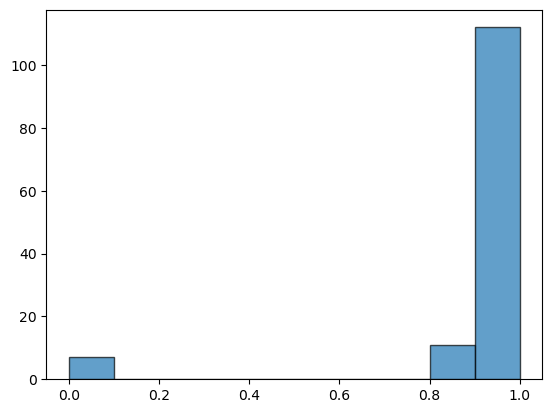

In [5]:
import matplotlib.pyplot as plt
plt.hist(derevation_scores, alpha=0.7, edgecolor='black', label='Derivation Scores')
plt.show()

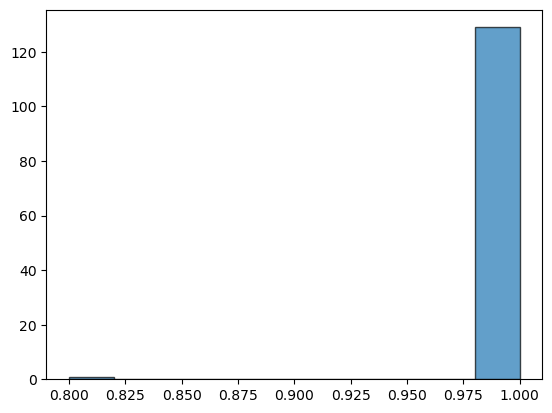

In [6]:
plt.hist(relevance_scores, alpha=0.7, edgecolor='black', label='Relevance Scores')
plt.show()